In [1]:
from __future__ import print_function, division
import pylab as pl
import numpy as np
import pandas as pd

from sklearn.ensemble  import RandomForestClassifier as rfc
#from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import statsmodels.api as sm
from sklearn.cross_validation import train_test_split
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import cdist
#from sklearn.cross_validation import train_test_split
%pylab inline

from IPython.display import Image
from IPython.display import clear_output
pl.rcParams['font.size'] = 20
#Image(filename = "Ridetypes.png")
import os
from collections import defaultdict
import sys

Populating the interactive namespace from numpy and matplotlib


In [2]:
mta = np.load('MTA_Fare2.npy')

In [3]:
mta.shape

(600, 23, 194)

In [4]:
mta_mean = mta.mean(axis=1)
mta_mean.shape

(600, 194)

Text(0.5,0,'Number of weeks')

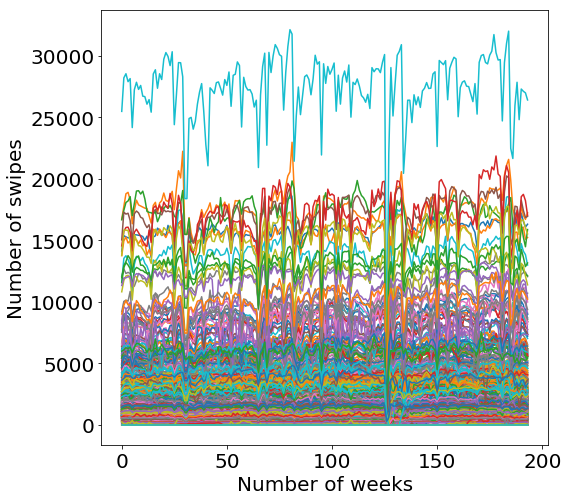

In [5]:
fig, ax = pl.subplots(figsize=(8,8))
for i in range(len(mta_mean)):
    ax.plot(mta_mean[i])
pl.ylabel('Number of swipes')
pl.xlabel('Number of weeks')

#### Figure 1: Plot showing the number of swipes at each station over the course of 194 weeks.

In [6]:
# N = timeframe = number of weeks = 194

timeframe = mta.shape[2]
timeframe

194

In [7]:
#Several stations show a prominent annual periodicity. Identify the 4 stations
#compress the cube along the card used type
mta_mean_stations = mta.mean(axis=1)
mta_mean_stations.shape

(600, 194)

In [8]:
frequency_stations = np.abs(np.fft.rfft(mta_mean_stations))**2
frequency_stations[0].shape

(98,)

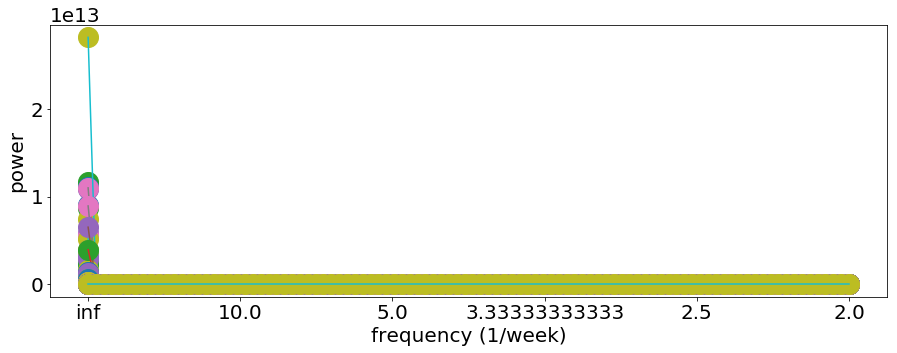

In [9]:
fig=pl.figure(figsize=(15,5))
ax=fig.add_subplot(111)

for i in range(600):
    ax.plot(np.fft.rfftfreq(timeframe, 1.0), (frequency_stations[i]), 'o', ms=20)
    ax.plot(np.fft.rfftfreq(timeframe, 1.0), (frequency_stations[i]), '-', label='Station' + str(i))

    
ax.set_xticklabels([ "%s"%(1/f) for f in ax.get_xticks()], fontsize=20)
pl.ylabel("power", fontsize=20)
pl.xlabel("frequency (1/week)", fontsize=20);
#pl.legend()

#### Figure 2: Power spectrum of the mta turnstile data with a weekly frequency.  The value at infinity is a very large number and that is true for all the stations

In [10]:
print (" The first two frequency (slowest) caculated are \n1: infinity (1.0/0) ",
       "and \n2:the frequency corresponding to the entire duration of the series = N*d,"
       " \nand they should be removed because they are uninteresting\n",
       "freq: ", np.fft.rfftfreq(timeframe, 1.0)[0], "= period: ", 1.0/np.fft.rfftfreq(timeframe, 1.0)[0], "and\n",
       "freq: ", np.fft.rfftfreq(timeframe, 1.0)[1], "= period: every %.1f"%(1.0/np.fft.rfftfreq(timeframe, 1.0)[1]), "weeks\n\n")

print ("The fastest frequency you can calculate id every 1.0/2*d, "
       "called the Nyquist frequency\n",
       np.fft.rfftfreq(timeframe, 1.0)[-1],  "or every %.1f"%(1.0/np.fft.rfftfreq(timeframe, 1.0)[-1]), "weeks")

 The first two frequency (slowest) caculated are 
1: infinity (1.0/0)  and 
2:the frequency corresponding to the entire duration of the series = N*d, 
and they should be removed because they are uninteresting
 freq:  0.0 = period:  inf and
 freq:  0.00515463917526 = period: every 194.0 weeks


The fastest frequency you can calculate id every 1.0/2*d, called the Nyquist frequency
 0.5 or every 2.0 weeks


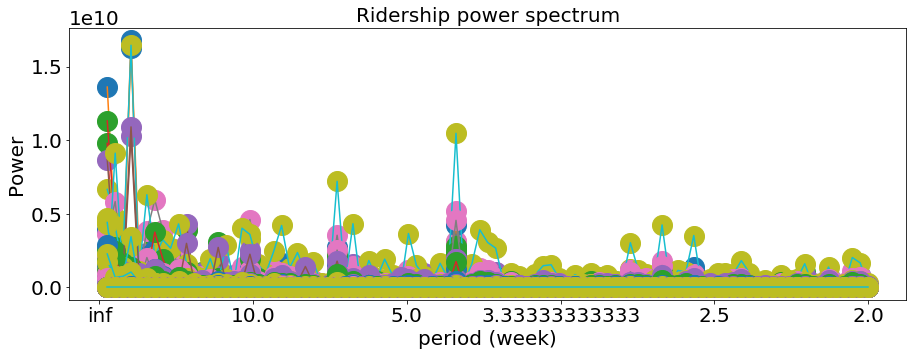

In [11]:
# removing the infinity value at 0 index as it skews the graph
fig=pl.figure(figsize=(15,5))
ax=fig.add_subplot(111)

for i in range(600):
    ax.plot(np.fft.rfftfreq(timeframe, 1.0)[1:], (frequency_stations[i])[1:], 'o', ms=20)
    ax.plot(np.fft.rfftfreq(timeframe, 1.0)[1:], (frequency_stations[i])[1:], '-', label='Station' + str(i))

ax.set_xticklabels([ "%s"%(1/f) for f in ax.get_xticks()], fontsize=20)
pl.xlabel("period (week)", fontsize=20)
pl.ylabel("Power", fontsize=20)
pl.title("Ridership power spectrum", fontsize=20);

#### Figure 3: Ridership power spectrum against frequency in weeks after the infinity value has been removed as it takes focus , causing us to ignore other values.

Text(0.5,1,'MTA Subway Turnstile Swipes Power Spectrum')

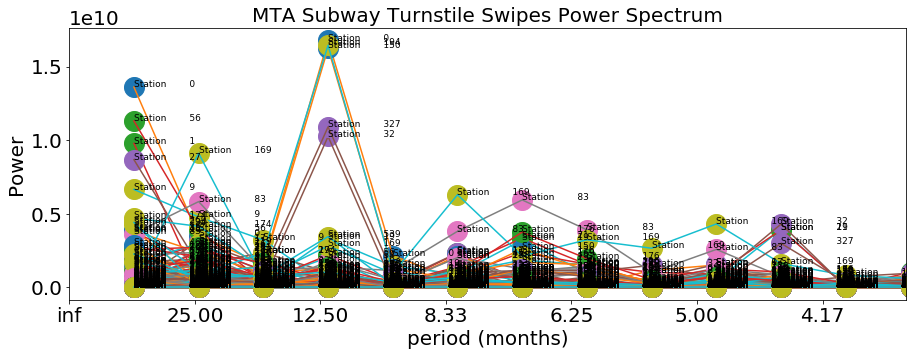

In [12]:
fig=pl.figure(figsize=(15,5))
ax=fig.add_subplot(111)

for i in range(600):
    ax.plot(np.fft.rfftfreq(timeframe, 1.0)[1:], (frequency_stations[i])[1:], 'o', ms=20)
    ax.plot(np.fft.rfftfreq(timeframe, 1.0)[1:], (frequency_stations[i])[1:], '-', label='Station' + str(i))
    for j in range(len(np.fft.rfftfreq(timeframe, 1.0)[1:])):
        ax.annotate("Station        " + str(i) , xy=[np.fft.rfftfreq(timeframe, 1.0)[1:][j],(frequency_stations[i])[1:][j]], fontsize=9, clip_on=True)
    
ax.set_xlim(0,1.0/15)
ax.set_xticklabels([ "%.2f"%(1/4./f) for f in ax.get_xticks()], fontsize=20)
pl.xlabel("period (months)", fontsize=20)
pl.ylabel("Power", fontsize=20)
pl.title("MTA Subway Turnstile Swipes Power Spectrum", fontsize=20)


#### Figure 3: Ridership power spectrum against frequency in months after the infinity value has been removed as it takes focus , causing us to ignore other values. There appears to be an annual periodicity at 12 months for a lot of stations.

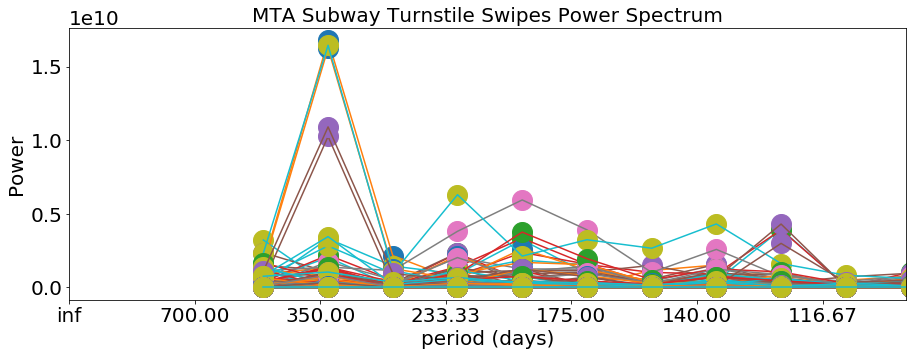

In [13]:
fig=pl.figure(figsize=(15,5))
ax=fig.add_subplot(111)

for i in range(600):
    ax.plot(np.fft.rfftfreq(timeframe, 1.0)[3:], (frequency_stations[i])[3:], 'o', ms=20)
    statin_ponts =   ax.plot(np.fft.rfftfreq(timeframe, 1.0)[3:], (frequency_stations[i])[3:], '-', label='Station' + str(i))
    
    
ax.set_xlim(0,1.0/15)
ax.set_xticklabels([ "%.2f"%(1*7./f) for f in ax.get_xticks()], fontsize=20)
pl.xlabel("period (days)", fontsize=20)
pl.ylabel("Power", fontsize=20)
pl.title("MTA Subway Turnstile Swipes Power Spectrum", fontsize=20);


#### Figure 4: Ridership power spectrum against frequency in days after the infinity value has been removed as it takes focus , causing us to ignore other values. There appears to be an annual periodicity at 365 days for a lot of stations.

### Identifying station ids on the data cube

In [15]:
#dentify the time period index for identifying stations with highest periodicity:
monthly_freq= 1/4./np.fft.rfftfreq(timeframe, 1.0)
monthly_freq

array([         inf,  48.5       ,  24.25      ,  16.16666667,
        12.125     ,   9.7       ,   8.08333333,   6.92857143,
         6.0625    ,   5.38888889,   4.85      ,   4.40909091,
         4.04166667,   3.73076923,   3.46428571,   3.23333333,
         3.03125   ,   2.85294118,   2.69444444,   2.55263158,
         2.425     ,   2.30952381,   2.20454545,   2.10869565,
         2.02083333,   1.94      ,   1.86538462,   1.7962963 ,
         1.73214286,   1.67241379,   1.61666667,   1.56451613,
         1.515625  ,   1.46969697,   1.42647059,   1.38571429,
         1.34722222,   1.31081081,   1.27631579,   1.24358974,
         1.2125    ,   1.18292683,   1.1547619 ,   1.12790698,
         1.10227273,   1.07777778,   1.05434783,   1.03191489,
         1.01041667,   0.98979592,   0.97      ,   0.95098039,
         0.93269231,   0.91509434,   0.89814815,   0.88181818,
         0.86607143,   0.85087719,   0.8362069 ,   0.8220339 ,
         0.80833333,   0.79508197,   0.78225806,   0.76

### The entry with the 4th index is 12.125 which is ~ 12 months / 1 year. We choose this index

In [16]:
# find the 4 number index of all stations in fft value and then sort the station id in decreasing order of this value
station_id_list = frequency_stations[:,4].argsort()[-4:].tolist()
print('Top 4 stations in ascending order of the highest annual peroidicity:')

print(station_id_list)

Top 4 stations in ascending order of the highest annual peroidicity:
[327, 150, 194, 0]


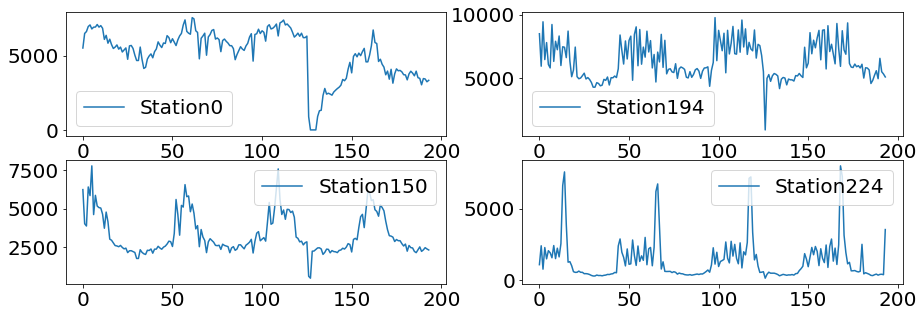

In [53]:
fig=pl.figure(figsize=(15,5))

ax1=fig.add_subplot(221)
ax1.plot(mta_mean[0],label='Station' + str(0))
pl.legend()

ax2=fig.add_subplot(222)
ax2.plot(mta_mean[194],label='Station' + str(194))
pl.legend()
ax3=fig.add_subplot(223)
ax3.plot(mta_mean[150],label='Station' + str(150))
pl.legend()
ax4=fig.add_subplot(224)
ax4.plot(mta_mean[327],label='Station' + str(224))
pl.legend()

#### Figure 5: Ridership for the top 4 stations having high annual peroidicity

# Task 5: Extra Credit

In [17]:
initial_labels = np.array([i for i in range(23)] * 600)
initial_labels.shape

(13800,)

In [18]:
# station - means
stationsmeans = mta.mean(axis=(1,2))
stationsmeans.shape

(600,)

In [19]:
stationsstd = mta.std(axis=(1,2))
stationsstd.shape

(600,)

In [20]:
#index of all stations taking values from 0 to 22 , each for 23 different types of cards
stationid = np.concatenate([np.array([i] * 23) for i in range(600)])

# obtain station id for the array of cardtype* station by weeks with std > 0
initial_labels[mta.reshape(600*23, 194).std(1) > 0]


valid_station_id = stationid[mta.reshape(600*23, 194).std(1) > 0]

In [21]:
final_labels = initial_labels[mta.reshape(600*23, 194).std(1) > 0]

In [22]:
mta.reshape(600*23,194)[mta.reshape(600*23, 194).std(1) > 0].shape

(9317, 194)

In [23]:
final_labels = initial_labels[mta.reshape(600*23, 194).std(1) > 0]

final_labels.shape

(9317,)

In [24]:

tots = mta.reshape(600*23,194)[mta.reshape(600*23, 194).std(1) > 0]
tots.shape

(9317, 194)

In [25]:
mean_ridership_mean_time_for_all_stations = np.nanmean( mta,axis=(1,2) )
std_ridership_std_time_for_all_stations = np.nanmean( mta,axis=(1,2) )

mean_ridership_per_timeseries_for_all_stations = np.nanmean(mta,axis=2)
std_ridership_per_timeseries_for_all_stations = np.nanmean(mta,axis=2)


In [26]:
normed_mean_ridership_for_all_stations = mean_ridership_per_timeseries_for_all_stations / mean_ridership_mean_time_for_all_stations.reshape(600,1)
normed_std_ridership_for_all_stations = std_ridership_per_timeseries_for_all_stations / std_ridership_std_time_for_all_stations.reshape(600,1)

normed_mean_ridership_for_all_stations_with_valid_timeseries = []
normed_std_ridership_for_all_stations_with_valid_timeseries = []
for i in range(len(final_labels)):
    normed_mean_ridership_for_all_stations_with_valid_timeseries.append(normed_mean_ridership_for_all_stations[valid_station_id[i]][final_labels[i]])
    normed_std_ridership_for_all_stations_with_valid_timeseries.append(normed_std_ridership_for_all_stations[valid_station_id[i]][final_labels[i]])

In [27]:
normed_time_series_mean = np.array(normed_mean_ridership_for_all_stations_with_valid_timeseries)
normed_time_series_std = np.array(normed_std_ridership_for_all_stations_with_valid_timeseries)

In [28]:
# mean of all time series for that station

mean_of_each_ts_per_station = mta.mean(axis=2)

std_of_each_ts_per_station = mta.std(axis=2)

sum_means_ts_all_stations = mean_of_each_ts_per_station.sum(axis=1)
sum_std_ts_all_stations = std_of_each_ts_per_station.sum(axis=1)


mean_of_each_ts_per_station.shape,std_of_each_ts_per_station.shape

((600, 23), (600, 23))

In [29]:
tsmean = np.nanmean(tots, axis=1)
tsmean.shape

(9317,)

In [30]:
tsstdev = np.nanstd(tots, axis=1)
tsstdev.shape

(9317,)

In [31]:
tots_mean = tots.mean(axis=1).reshape(9317,1)
tots_std = tots.std(axis=1).reshape(9317,1)
standardizedts = (tots - tots_mean )/ tots_std

In [32]:
standardizedts1 = pd.DataFrame(standardizedts.T)

In [33]:
week_number = np.array([[i for i in range(194)] for i in range(standardizedts1.shape[1])])

In [34]:
standardizedts1 .shape

(194, 9317)

In [35]:
week_number.shape

(9317, 194)

In [36]:
allfit =sm.OLS(standardizedts1,week_number.T).fit()


In [37]:
Features =  np.array([allfit.params[0].values, allfit.params[1].values, 
              np.mean(standardizedts)/normed_time_series_mean, np.std(standardizedts)/normed_time_series_std]).T
Features.shape

(9317, 4)

In [38]:
Features[~np.isfinite(Features)] = 0

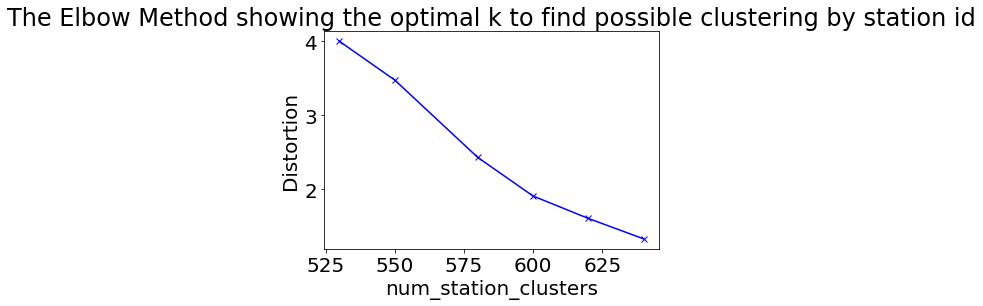

In [39]:
num_station_clusters = [530,550,580,600,620,640]
distortions = []

for num_station_cluster in num_station_clusters:
    kmeanModel = KMeans(n_clusters=num_station_cluster).fit(Features)
    kmeanModel.fit(Features)
    distortions.append(sum(np.min(cdist(Features, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / Features.shape[0])

# Plot the elbow
pl.plot(num_station_clusters, distortions, 'bx-')
pl.xlabel('num_station_clusters')
pl.ylabel('Distortion')
pl.title('The Elbow Method showing the optimal k to find possible clustering by station id')
pl.show()


### Interpretation:

* Metric = minimum distance of the feature to the cluster centorids


* Based on the elbow plot, it appears to correctly identify the number of stations.

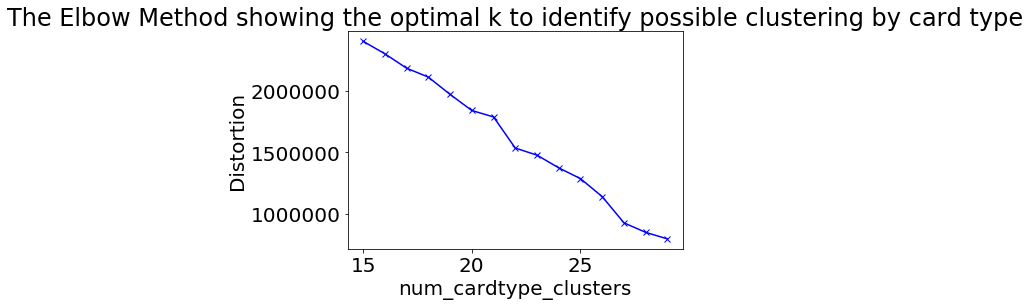

In [40]:
num_cardtype_clusters = range(15,30)
distortions = []
from scipy.spatial.distance import cdist
for num_cardtype_cluster in num_cardtype_clusters:
    kmeanModel = KMeans(n_clusters=num_cardtype_cluster).fit(Features)
    kmeanModel.fit(Features)
    distortions.append(sum(np.min(cdist(Features, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / Features.shape[0])

# Plot the elbow
pl.plot(num_cardtype_clusters, distortions, 'bx-')
pl.xlabel('num_cardtype_clusters')
pl.ylabel('Distortion')
pl.title('The Elbow Method showing the optimal k to identify possible clustering by card type')
pl.show()


### Interpretation:

* Metric = minimum distance of the feature to the cluster centorids


* Lower cluster distance based on the above metric when number of clusters = 600 in the first graph indicates that the clustering by station id is better than that of the card type.

In [41]:
# Identifying clusters for timestamps

features_194 = pd.DataFrame(tots)

In [42]:
features_194 = features_194 - features_194.mean(0) / features_194.std(0)

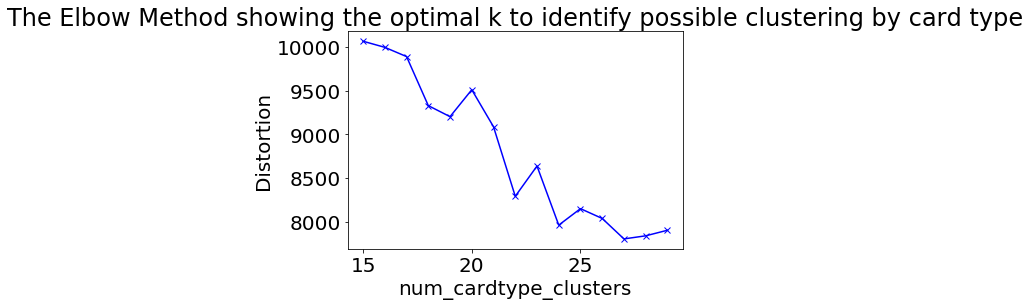

In [43]:
num_cardtype_clusters = range(15,30)
distortions = []

for num_cardtype_cluster in num_cardtype_clusters:
    kmeanModel = KMeans(n_clusters=num_cardtype_cluster).fit(features_194)
    kmeanModel.fit(features_194)
    distortions.append(sum(np.min(cdist(features_194, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / features_194.shape[0])

# Plot the elbow
pl.plot(num_cardtype_clusters, distortions, 'bx-')
pl.xlabel('num_cardtype_clusters')
pl.ylabel('Distortion')
pl.title('The Elbow Method showing the optimal k to identify possible clustering by card type')
pl.show()



#### Interpretation:
* Does not seem to accurately identify cluster.
* Also no elbow present

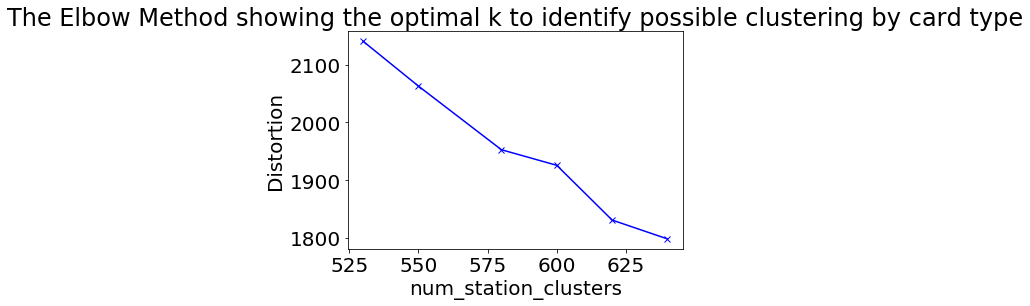

In [44]:
num_station_clusters = [530,550,580,600,620,640]
distortions = []

for num_station_cluster in num_station_clusters:
    kmeanModel = KMeans(n_clusters=num_station_cluster).fit(features_194)
    kmeanModel.fit(features_194)
    distortions.append(sum(np.min(cdist(features_194, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / features_194.shape[0])

# Plot the elbow
pl.plot(num_station_clusters, distortions, 'bx-')
pl.xlabel('num_station_clusters')
pl.ylabel('Distortion')
pl.title('The Elbow Method showing the optimal k to identify possible clustering by card type')
pl.show()

#### Interpretation:
* Does not seem to accurately identify cluster.
* Also no elbow present